The Hough transform is a technique which can be used to isolate features of a particular shape within an image. It was originally proposed to detect lines [Richard&Peter, 1971](http://www.ai.sri.com/pubs/files/tn036-duda71.pdf).

Tutorials:
1. [Hough Transform](http://homepages.inf.ed.ac.uk/rbf/HIPR2/hough.htm)
2. [Colorado School of Mines, Hough transform](https://inside.mines.edu/~whoff/courses/EENG512/lectures/13-Hough.pdf)
3. [Understanding Hough Transform With Python](https://alyssaq.github.io/2014/understanding-hough-transform/)
4. [Generalize Hough transform to detect arbitrary shapes](http://www.eng.tau.ac.il/~cvapps/Supplement/%5B%201981%20%5D%20Generalizing%20the%20Hough%20Transform%20to%20Detect%20Arbitrary%20Shapes.pdf)

# Normal form / polar coordinate representation of a line
The normal paramters for a line are illustrated below
![image](./img/line_normal_form.png)
Supposing the line is neither vertical nor horizontal, i.e., the two intercepts are both non-zero, then the slope-intercept representation of the line is 
\begin{equation}
y = kx + b = -\frac{y_0}{x_0}x + y_0
\end{equation}
From the above figure, where the distance $\rho\ge 0$ and the angle $\theta\in[0, 2\pi)$, it is easy to obtain taht 
\begin{equation}
cos\theta=\frac{\rho}{x_0}, \quad, sin\theta=\frac{\rho}{y_0}.
\end{equation}
Now replacing $x_0$ and $y_0$ with the correponding expression using $\rho$ and $\theta$, we can get 
\begin{equation}
\rho = xcos\theta + ysin\theta.
\end{equation}
What's more, it is also straightforward to verify that the above equation holds even when the slope is infinite (vertical line) or the line is horizontal. It is called the **normal form or polar coordinate representation** of a straight line in 2D space.

*Intercept form to normal form*  
From the above equation (2), we have 
\begin{equation}
\rho^2 = \frac{x_0^2 y_0^2}{x_0^2 + y_0^2}.
\end{equation}
After we get $\rho$, it is straightforward to get the angle $\theta$.

*Why do we use the normal form?*  
Because the slope-intercept form can not handle the special case when the line is vertical.

# Hough transform of lines
For each line in the 2D coordinate, it correponds to a single point $(\theta, \rho)$ in the parameter space. On the handle, given a single point $p1=(x_1, y_1)$ in the 2D coordinate (or call it image space if we are processing an image), all the possible lines passing through this point are transformed into the parameter space by 
\begin{equation}
\rho = x_1 cos\theta + y_1 sin\theta.
\end{equation}
Using some trigonometry knowledge, we can show that the above equation actually depicts a sinusoidal curve $s_1$ in the parameter space.

If we have another point in the original 2D space, $p2=(x_2, y_2)$, then similarly it will yield another sinusoid $s_2$ in the parameter space. More importantly, consider the straight line $l_{12}$ passing through the two points, and it is obvious that $l_{12}$ is also characterized by a pair of unique parameters $(\theta_{12}, \rho_{12})$, which should be the common point of $s_1$ and $s_2$. This conclusion can be generalized to any number of points on a single line in the 2D coordinate image space.

> What does all the stuff above mean? It means that in general, a line can be detected by finding the number of intersections between curves.The more curves intersecting means that the line represented by that intersection have more points. In general, we can define a threshold of the minimum number of intersections needed to detect a line.

In other words, if there are multiple points $p_i, i=1,2,\cdots,m$ on the same line in the image space, then there must exist a certain $\theta^*$ such that $\rho^* = x_i cos\theta^* + y_i sin\theta^*$ yields the same value for all $i$. And in the parameter space, such a point $(\theta^*, \rho^*)$ is just the intersection point of all the $m$ sinusoids in the parameter space.

However, in reality, these points, like pixels on an image, are usually corrupted by noise, which means in most cases not all the $m$ points give the same $\rho$ value for the ideal $\theta^*$. However, we can be sure that all the generated $\rho$ values should be quite close for the $\theta^*$, which is assumed to be known for now. Now the question is that $\theta^*$ is unknown. 

Fortunately, since $\theta$ is bounded, we can test each possible value. Of course, in practice, we have to discretize $\theta$ to a finite set of values to be examined. Similarly, the value of $\rho$ is also binned. Now by quantizing the Hough parameter space into finite intervals, we get the so-called *accumulator cell array*. 

**Algorithm**
- Initialize the 2D cell array H by quantizing $\theta$ and $\rho$ in a specified range into proper intervals.
- For each point $(x_i, y_i)$
    - For each discretized $\theta$ value, compute the corresponding $\rho = x_i cos\theta + y_i sin\theta$.
    - Increment (add 1 to) the cell in H corresponding to $(\theta, \rho)$, known as *Voting in the accumulator*
- Find the local maxima with most votes according to certain criteria, which are concluded as the lines in the original image space.

![image](./img/hough-line.png)

## Range of $\theta$ and $\rho$
In actual implementation, for simplicity and speed, we usually choose the range of the angle $\theta$ as $[0^\circ, 180^\circ)$, while the algebraic distance $\rho$ can be negative in this case. If $\rho$ is negative, it simply means we should use the perpendicular distance in the opposite direction.  
Regaring $\rho$, its range is defined according prior knowledge. For example, in image processing, the maximum possible value of $\rho$ is the length of the diagonal.
![image](./img/negative-rho.png)
In libraries such as MATLAB and opencv, they may have different definitions of the range of $\theta$. However, they are actually equivalent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# A Toy Example for Line Detection
In real image processing, the firs step is usually edge detection.  The resultant binary/grey image will have 0s indicating non-edges and 1s or above indicating edges. However, here for simplicity, supposing we have three lines to be detected, 7, 8, 9 points are present for each line respectively. Our task is to adopt Hough transform to find these three lines from all the points.

Three lines in two-intercept form:
\begin{align}
x + y &= 1 \\
\frac{x}{5} + \frac{y}{-3} &= 1 \\
\frac{x}{-8} + \frac{y}{6} &= 1
\end{align}

Let's first assume we know the lines exactly, and compute the corresponding $(\theta, \rho)$ parameters.
### Ground truth

In [2]:
import numpy as np
def compute_polar_parameters(x0, y0):
    """
    @param x0 array of x-axis intersects
    @param array of y-axis intersects
    @return theta (in degrees of range [0, 180)) and rho (non-negative)
    """
    rho = np.sqrt((x0**2 * y0**2) / (x0**2 + y0**2))
    # np.arccos --> [0, pi]. However, according to our definition, rho can be negative in fact.
    # if y0 < 0, then rho should be negative
    rho = ((y0 > 0) * 2 - 1) * rho
    theta = np.arccos(rho / x0)
    
    return np.rad2deg(theta), rho

In [3]:
x0 = np.array([1, 5, -8])
y0 = np.array([1, -3, 6])
theta, rho = compute_polar_parameters(x0, y0)
print('theta (degree): ', theta)
print('rho: ', rho)

theta (degree):  [ 45.         120.96375653 126.86989765]
rho:  [ 0.70710678 -2.57247878  4.8       ]


### Generate data points
 7, 8, 9 points for three lines respectively, with no noise and $x\in[-20, 20]$.
 \begin{equation}
 \frac{x}{x_0} + \frac{y}{y_0} = 1 \Rightarrow y = -\frac{y_0}{x_0}x + y_0
 \end{equation}

In [4]:
np.random.seed(213)
x_list = []
y_list = []
for i, n in enumerate([20, 30, 40]):
    xi = np.random.randint(-20, 21, n)
    yi = -y0[i] / x0[i] * xi + y0[i]  # ith line
    x_list.append(xi)
    y_list.append(yi)
# concatenate the x and y arrays into single ones: xi and yi are both 1d arrays
x = np.hstack(x_list)
y = np.hstack(y_list)
print(x.shape, y.shape)

(90,) (90,)


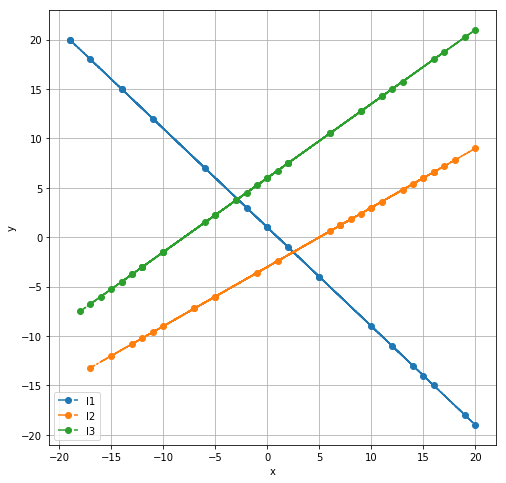

In [5]:
# visualization
fig = plt.figure(figsize=(8, 8))
for xl, yl in zip(x_list, y_list):
    plt.plot(xl, yl, 'o-.')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['l1', 'l2', 'l3'])

### Line detection with Hough transform


Besides, we know that since the range for both axes is $[-20, 20]$, the maximum possible $\rho$ is about 28, i.e., $\rho\in[-28, 28]$. Let's discretize the two parameters with resolution 0.1.
#### （1） Initialize the accumulator array
Let rows denote $\rho$ and columns denote $\theta$. Then, we need a 2D array, or called *accumulator*, of size $(570, 1800)$, which is initialized to be all zero. 

In [6]:
acc = np.zeros((561, 1800), dtype=np.int)

In [7]:
def rho2index(val):
    """
    Given a value of rho, convert it to the row index.
    """
    return int(round(val * 10 + 280))

def index2rho(i):
    """
    Given a row index, transform it to the corresponding rho value.
    """
    return (i - 280) / 10

#### (2) Voting
For each point and each quantized $\theta$ value, compute $\rho$ and increment the value of the bin at $(\rho, \theta)$ by one. This value represents the number of votes. 

In [8]:
import math
for xp, yp in zip(x, y):
    for theta in np.arange(0, 180, 0.1):
        rho = xp * math.cos(math.radians(theta)) + yp * math.sin(math.radians(theta))
        rho = min(28, max(-28, rho))
        # increment
        row_index = rho2index(rho)
        theta_index = int(theta * 10)
        acc[row_index, theta_index] += 1

#### (3) peak finding
By finding the bins with the highest values, typically by looking for local maxima in the accumulator space, the most likely lines can be extracted, and their (approximate) geometric definitions read off. The simplest way of finding these peaks is by applying some form of threshold.

In this case, we will find bins (cells) which has at least 20 votes.

In [9]:
indices = np.argwhere(acc >= 20)
indices

array([[ 254, 1209],
       [ 254, 1210],
       [ 254, 1211],
       [ 287,  450],
       [ 328, 1267],
       [ 328, 1268],
       [ 328, 1269],
       [ 328, 1270],
       [ 328, 1271]], dtype=int64)

In [10]:
# get the corresponding (theta, rho) and the associated votes
for i, j in indices:
    rho = index2rho(i)
    theta = j / 10
    print(f'theta = {theta}, rho = {rho}, #votes = {acc[i, j]}')

theta = 120.9, rho = -2.6, #votes = 29
theta = 121.0, rho = -2.6, #votes = 30
theta = 121.1, rho = -2.6, #votes = 22
theta = 45.0, rho = 0.7, #votes = 20
theta = 126.7, rho = 4.8, #votes = 30
theta = 126.8, rho = 4.8, #votes = 40
theta = 126.9, rho = 4.8, #votes = 40
theta = 127.0, rho = 4.8, #votes = 36
theta = 127.1, rho = 4.8, #votes = 22


**Conclusion:** as we see, Hough transform has found all possible lines including the exact three ones. This is due to the error caused by finite discretization.  
In practical implementation, we should vectorize the above codes with `numpy` to avoid expensive for loops for better time efficiency.

# Circle detection with Hough transform